# CPS Labor Force Nonparticipation by Reason

Brian Dew, @bd_econ

Replaces CPS_PrimeLF_Contrib.ipynb

March 19, 2019

Replication using python of a very clever chart by Ernie Tedeschi (@ernietedeschi).

[Definitions](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of labor market status come from the FRB of Atlanta.

In [1]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

os.chdir('/home/brian/Documents/CPS/data/clean/')

In [2]:
# Age and sex demographics in March 2001
filter_cols = ['AGE', 'FEMALE', 'NILFREASON', 'BASICWGT', 'MONTH']
df = (pd.read_feather('cps2001.ft', columns=filter_cols)
        .query('MONTH == 3 and 18 <= AGE <= 64'))

# Create dictionary with sex and age distribution in March 2001
dem_2001 = {}
for sex in [0, 1]:
    dfs = df[df['FEMALE'] == sex]
    age_dict = (dfs.groupby('AGE').BASICWGT.sum()
                / dfs.BASICWGT.sum()).to_dict()
    for age in age_dict.keys():
        dem_2001[(sex, age)] = age_dict[age]

In [3]:
results = pd.DataFrame()

for year in range(2000, 2021):
    annual_data = (pd.read_feather(f'cps{year}.ft', columns=filter_cols)
                     .query('18 <= AGE <= 64'))
    for month, df in annual_data.groupby('MONTH'):
    
        date = pd.to_datetime(f'{year}-{month}-01')

        dem_adj = {}
        for sex in [0, 1]:
            dfs = df[df['FEMALE'] == sex]
            age_dict = (dfs.groupby('AGE').BASICWGT.sum()
                        / dfs.BASICWGT.sum()).to_dict()
            for age in age_dict.keys():
                dem_adj[(sex, age)] = dem_2001[(sex, age)] / age_dict[age]

        df['COMBO'] = list(zip(df['FEMALE'], df['AGE']))
        df['ADJWGT'] = df['COMBO'].map(dem_adj) * df['BASICWGT']

        s = df.groupby('NILFREASON').ADJWGT.sum() / df.ADJWGT.sum()
        unadj = (df.groupby('NILFREASON').BASICWGT.sum()
                 / df.BASICWGT.sum()).nan
        monthly_result = s.to_frame(name=date).T
        monthly_result.at[date, 'nan'] = s.nan - unadj

        results = results.append(monthly_result)

results = results.rename({'nan': 'Demographics'}, axis=1).rolling(12).mean()
results = results.dropna().loc['2001-03-01':] * 100
final = results.iloc[0] - results

<ipython-input-3-d7130f0e16f1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['COMBO'] = list(zip(df['FEMALE'], df['AGE']))
<ipython-input-3-d7130f0e16f1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ADJWGT'] = df['COMBO'].map(dem_adj) * df['BASICWGT']


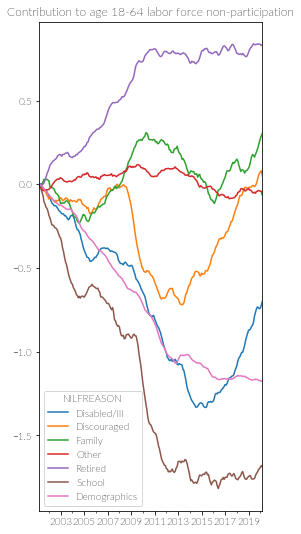

In [4]:
%matplotlib inline
title='Contribution to age 18-64 labor force non-participation'
final.plot(figsize=(4, 9), title=title);

In [5]:
subset = ['Disabled/Ill', 'Discouraged', 'Family', 'Retired', 'School', 'Demographics']

file = '/home/brian/Documents/uschartbook/chartbook/data/nilf.csv'

final[subset].to_csv(file, index_label='date', float_format='%g')

colors = {'Disabled/Ill': 'green!80!blue', 'Discouraged': 'blue', 'Family': 'red', 
          'Retired': 'orange', 'School': 'cyan', 'Demographics': 'violet!80!purple'}

date = results.index[-1].strftime('%Y-%m-%d')

myfile = open('/home/brian/Documents/uschartbook/chartbook/text/nilf_nodes.txt', 'w')

for name, color in colors.items():
    
    val = final[name].iloc[-1]
    
    valtext = f'{val:.1f}'

    text2 = (f'\\node[label={{0:{{\\footnotesize {valtext}}}}}, circle, {color}, fill, inner sep=1.35pt] at'+
             f'(axis cs:{date}, {val}) {{}};')

    myfile.write(text2)
    
myfile.close()

In [6]:
ltdate = results.index[-1].strftime('%B %Y')
tot = abs(final.iloc[-1].sum())
dem = abs(final['Demographics'].iloc[-1].sum())
sch = abs(final['School'].iloc[-1].sum())
dis = abs(final['Disabled/Ill'].iloc[-1].sum())
ret = abs(final['Retired'].iloc[-1].sum())

text = (f'From March 2001 to the latest available month, {ltdate}, '+
        f'an additional {tot:.1f} percent of the age 18--64 population '+
        f'left the labor force. The larger-than-normal population '+
        f'cohort born after World War II is reaching retirement age in '+
        f'this period. Such demographic effects explain {dem:.1f} '+
        f'percentage points of the cumulative decrease. Additionally, '+
        f'young people are staying in school longer, on average, '+
        f'reducing the age 18--64 labor force by {dem:.1f} percent. '+
        f'Disability and illness reduce the labor force by '+
        f'another {dis:.1f} percent. Less retirement among those age '+
        f'18--64 increases the labor force by {ret:.1f} percent.')


write_txt('/home/brian/Documents/uschartbook/chartbook/text/nilf_01.txt', text)

text

'From March 2001 to the latest available month, March 2020, an additional 2.4 percent of the age 18--64 population left the labor force. The larger-than-normal population cohort born after World War II is reaching retirement age in this period. Such demographic effects explain 1.2 percentage points of the cumulative decrease. Additionally, young people are staying in school longer, on average, reducing the age 18--64 labor force by 1.2 percent. Disability and illness reduce the labor force by another 0.7 percent. Less retirement among those age 18--64 increases the labor force by 0.8 percent.'